     Subject  Start_Time From  To  Sojourn_Time  Censored
0          0    0.000000   S0  S3      0.167187         1
1          1    0.000000   S0  S3      6.404175         1
2          2    0.000000   S0  S3      0.295432         1
3          3    0.000000   S0  S1      0.738887         1
4          3    0.738887   S1  S0      1.264434         1
..       ...         ...  ...  ..           ...       ...
151       48    9.629272   S1  S1      0.370728         0
152       49    0.000000   S0  S0      3.003108         1
153       49    3.003108   S0  S0      1.565314         1
154       49    4.568421   S0  S1      1.576063         1
155       49    6.144484   S1  S3      2.617014         1

[156 rows x 6 columns]


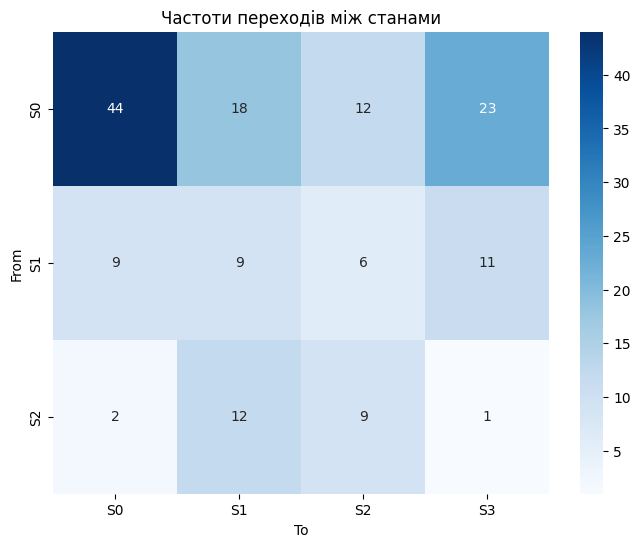

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Параметри моделювання
M = 50  # кількість суб'єктів
Tmax = 10  # максимальний час спостереження
N_states = 4  # кількість станів
state_names = [f'S{i}' for i in range(N_states)]

# Генерація випадкової матриці переходів (рядки сумуються до 1)
def generate_transition_matrix(n):
    mat = np.random.dirichlet(np.ones(n), size=n)
    return pd.DataFrame(mat, index=state_names, columns=state_names)

transition_probs = generate_transition_matrix(N_states)

# Випадкове призначення базових інтенсивностей і типу розподілу
lambda_0 = {state: np.random.uniform(0.1, 1.0) for state in state_names}
lambda_type = {state: np.random.choice(['exp', 'unif']) for state in state_names}

# Функція для генерації наступного стану
def sample_next_state(current):
    return np.random.choice(state_names, p=transition_probs.loc[current].values)

# Функція для генерації часу перебування
def generate_sojourn_time(current_state, Z):
    lam = lambda_0.get(current_state, 1.0)
    if lambda_type[current_state] == 'exp':
        rate = lam * np.exp(Z)
        u = np.random.uniform(0, 1)
        return -np.log(1 - u) / rate
    else:  # рівномірний розподіл
        low = 0.5
        high = lam + np.exp(Z)
        return np.random.uniform(low, high)

# Основний алгоритм
records = []
for m in range(M):
    t = 0
    state = state_names[0]  # Початковий стан
    Z_m = {(i, j): np.random.normal(0, 1) for i in state_names for j in state_names if j != i}

    while t < Tmax and state != state_names[-1]:  # останній стан — absorbing
        current_state = state
        next_candidate = sample_next_state(current_state)
        Z = Z_m.get((current_state, next_candidate), 0)
        W = generate_sojourn_time(current_state, Z)

        if t + W > Tmax:
            W = Tmax - t
            censored = 0
            next_state = current_state
        else:
            censored = 1
            next_state = next_candidate

        records.append({
            'Subject': m,
            'Start_Time': round(t, 6),
            'From': current_state,
            'To': next_state,
            'Sojourn_Time': round(W, 6),
            'Censored': censored
        })

        t += W
        state = next_state

# Зберігаємо як DataFrame
sim_data = pd.DataFrame(records)

# Вивід перших рядків
print(sim_data)

# Побудова графіка переходів (матриця частот)
transition_counts = sim_data.groupby(['From', 'To']).size().unstack(fill_value=0)
plt.figure(figsize=(8, 6))
sns.heatmap(transition_counts, annot=True, fmt='d', cmap='Blues')
plt.title("Частоти переходів між станами")
plt.show()
